In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

In [2]:
def Θ(x, x_rev, λ, θ):
    xk, xj = np.meshgrid(x, x)
    return (xj - x_rev)/(1 + np.exp(-λ*(xk - θ)))

In [3]:
def dΘ_dx(x, λ, θ):
    final = np.ones((x.size, x.size))*1/(1 + np.exp(-λ*(x - θ)))
    np.fill_diagonal(final, final.diagonal() + x*λ*np.exp(-λ*(x - θ))/(1+np.exp(-λ*(x - θ)))**2)
    return final

In [4]:
def hr_dots(current, t0, b, i0, x_rev, λ, θ, μ, s, x_rest, α, n1, β, n2, G1, G2):
    x, y, z = map(lambda k: k.flatten(), np.split(current, 3))
    theta = Θ(x, x_rev, λ, θ)
    dots = np.zeros_like(current).reshape(3, -1)
    dots[0] = y - (x**3) + b*(x**2) + i0 - z - (α/n1)*np.sum(G1*theta, axis=1) - (β/n2)*np.sum(G2*theta, axis=1)
    dots[1] = 1 - 5*(x**2) - y
    dots[2] = μ*(s*(x - x_rest) - z)
    return np.hstack([dots[i] for i in range(3)])

In [5]:
def jac(_, y_in):
    x, y, z = map(lambda k: k.flatten(), np.split(y_in, 3))
    dtheta_dx = dΘ_dx(x, λ, θ)
    dẋ_dx = -3*x**2 + 2*b*x - (α/n1)*G1*dtheta_dx - (β/n2)*G2*dtheta_dx
    dẋ_dy = np.ones_like(dẋ_dx)
    dẋ_dz = -np.ones_like(dẋ_dy)

    dẏ_dx = -10*x*np.ones_like(dẋ_dz)
    dẏ_dy = -np.ones_like(dẏ_dx)
    dẏ_dz = np.zeros_like(dẏ_dy)

    dż_dx = μ*s*np.ones_like(dẏ_dz)
    dż_dy = np.zeros_like(dż_dx)
    dż_dz = -μ*np.ones_like(dż_dy)

    j_x = [dẋ_dx, dẋ_dy, dẋ_dz]
    j_y = [dẏ_dx, dẏ_dy, dẏ_dz]
    j_z = [dż_dx, dż_dy, dż_dz]

    return np.vstack([np.hstack(j_x), np.hstack(j_y), np.hstack(j_z)])

In [6]:
def cortex_size(mask, val):
    return int(np.sqrt(mask[mask == val].shape))

In [7]:
n = np.loadtxt("connectomes/cat_connectome")/3
cortex_mask = np.zeros_like(n)
cortex_mask[:18, :18] = 1
cortex_mask[18:28, 18:28] = 2
cortex_mask[28:45, 28:45] = 3
cortex_mask[45:, 45:] = 4
G1 = n.copy()
G1[cortex_mask == 0] = 0
G2 = n.copy()
G2[cortex_mask != 0] = 0

In [8]:
# For validation
for i in [1, 2, 3, 4]:
    print(i, cortex_size(cortex_mask, i))

1 18
2 10
3 17
4 20


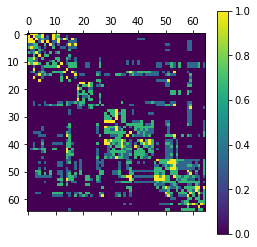

In [9]:
plt.matshow(n)
plt.colorbar()
plt.savefig("tmp", dpi=600)

In [10]:
b = 3.2                           # Controls spiking frequency
i0 = 4.4*np.ones(n.shape[0])      # Input current ---- It's an array so we can add noise later
x_rev = 2                         # Reverse potential
λ = 10                            # Sigmoidal function parameter
θ = -0.25                         # Sigmoidal function parameter
μ = 0.01                          # Time scale of slow current
s = 4.0                           # Governs adaptation (whatever that means)
x_rest = 1.6                      # Resting potential
α = 0.210                         # Intra connection strength ---- VARIED PARAMETER
n1 = np.count_nonzero(G1, axis=1) # Number of intra connections from a given neuron
n1[n1 == 0] = 1                   # This is to remove a divide-by-zero; if n1 is 0, then so is G1
β = 0.040                         # Inter connection strength ---- VARIED PARAMETER
n2 = np.count_nonzero(G2, axis=1) # Number of inter connections from a given neuron
n2[n2 == 0] = 1                   # This is to remove a divide-by-zero; if n2 is 0, then so is G2

In [11]:
ivs = np.zeros([3, n.shape[0]])   # Initial values [[x], [y], [z]]
ivs[0] = 4*np.random.random(n.shape[0]) - 2
ivs[1] = 0.2*np.random.random(n.shape[0])
ivs[2] = 0.2*np.random.random(n.shape[0])

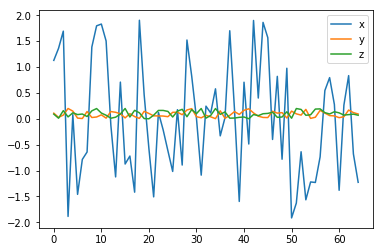

In [12]:
plt.plot(ivs[0], label="x")
plt.plot(ivs[1], label="y")
plt.plot(ivs[2], label="z")
plt.legend()

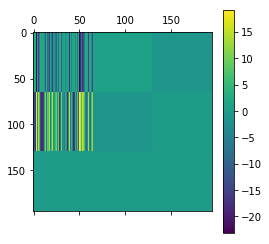

In [13]:
plt.matshow(jac(0, ivs))
plt.colorbar()

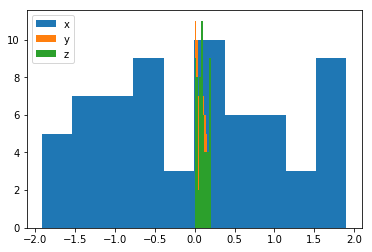

In [14]:
plt.hist(ivs[0], label="x")
plt.hist(ivs[1], label="y")
plt.hist(ivs[2], label="z")
plt.legend()

In [15]:
params = (b, i0, x_rev, λ, θ, μ, s, x_rest, α, n1, β, n2, G1, G2)

In [16]:
tmax = 4000
N = 100*tmax
t = np.linspace(0, tmax, N)

In [17]:
def plot_end(start, end, p=0.99, legend=True, title=True):
    for i in range(start, end):
        plt.plot(vals[int(p*vals.shape[0]):, 0, i], label=i)
    if legend:
        plt.legend(loc="lower left")
    if title:
        plt.title(f"Last {100 - 100*p}% of neurons {start} - {end}")

In [18]:
def plot_beginning(start, end, p=0.01, legend=True, title=True):
    for i in range(start, end):
        plt.plot(vals[:int(p*vals.shape[0]), 0, i], label=i)
    if legend:
        plt.legend(loc="lower right")
    if title:
        plt.title(f"First {100*p}% of neurons {start} - {end}")

In [19]:
%%time
sol = solve_ivp(fun=lambda t_in, y_in: hr_dots(y_in, t_in, *params),
                t_span=(0, tmax), y0=ivs.reshape(ivs.size),
                max_step=1e-1, dense_output=True, method="RK45")

Wall time: 46 s


In [20]:
tmax/len(sol.t)

0.09999250056245781

In [21]:
vals = sol.sol(t).T

In [22]:
vals = vals.reshape(-1, 3, 65)

In [23]:
vals.shape

(400000, 3, 65)

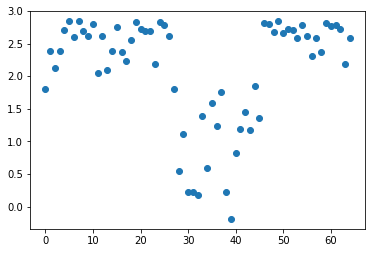

In [24]:
plt.plot(vals[-1, 0, :], "o")

In [25]:
pb = 0.0025
pe = 1 - pb

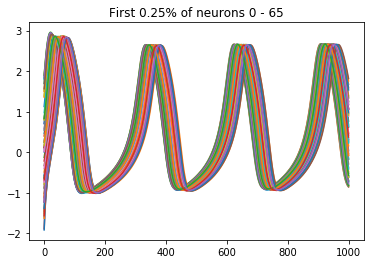

In [26]:
plot_beginning(0, 65, legend=False, p=pb)

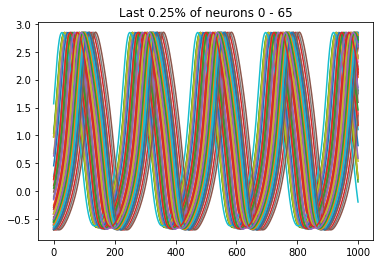

In [27]:
plot_end(0, 65, legend=False, p=pe)

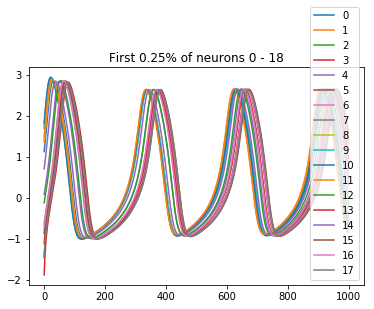

In [28]:
plot_beginning(0, 18, p=pb)

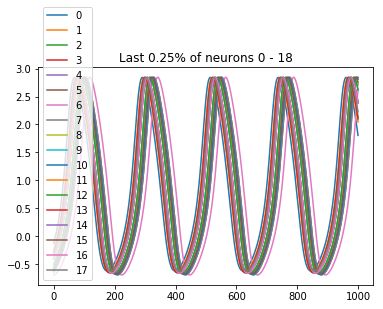

In [29]:
plot_end(0, 18, p=pe)

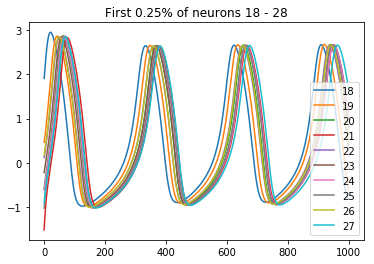

In [30]:
plot_beginning(18, 28, p=pb)

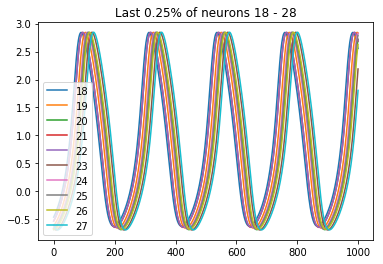

In [31]:
plot_end(18, 28, p=pe)

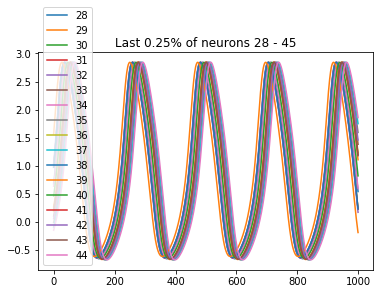

In [32]:
plot_end(28, 45, p=pe)

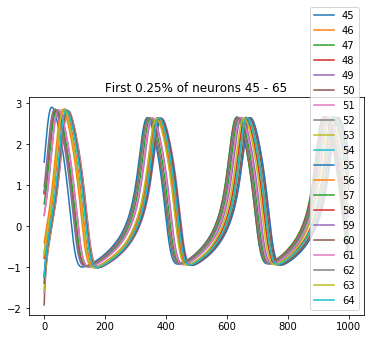

In [33]:
plot_beginning(45, 65, p=pb)

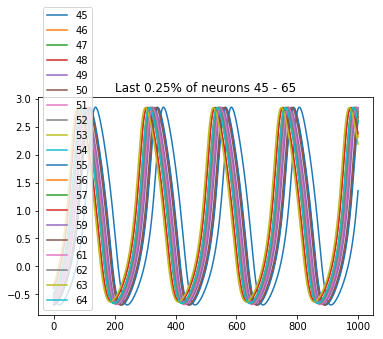

In [34]:
plot_end(45, 65, p=pe)

# DOCSTRING FOR hr_dots
    """Return the time derivative of the degrees of freedom of the Hindmarsh-Rose neural model
    
    Returns an array of [dx0/dt, ..., dxN/dt, dy0/dt, ..., dyN/dt, dz0/dt, ..., dzN/dt] for
    the Hindmarsh-Rose neural model.
    
    The reason it accepts and returns a 1D array is that it is intended to be used with
    scipy.integrate.odeint, which only accepts 1D arrays.
    
    Parameters
    ----------
    current_1d : np.ndarray
        Current values of [x0, ..., xN, y0, ..., yN, z0, ..., zN]
    t0 : int
        Time.  Since the HR model is autonomous, it doesn't matter,
        it's just there for scipy.integrate.odeint
    b : float
        Controls spiking frequency
    i0 : np.ndarray
        Input current.  Of the form [i00, ..., i0N]
    x_rev : float
        Reverse potential
    λ : float
        Sigmoidal function steepness
    θ : float
        Sigmoidal function center
    μ : float
        Time scale of the slow current
    s : float
        Governs adaptation
    x_rest : float
        Resting potential
    α : float
        Intra connection strength
    n1 : np.ndarray
        Number of intra connections per neuron
    β : float
        Inter connection strength
    n2 : np.ndarray
        Number of inter connections per neuron
    adj : np.ndarray
        Adjacency matrix for the connectome
    cortex_mask : np.ndarray
        Mask indicating which cortex each neuron belongs to
        
    Returns
    -------
    np.ndarray
        Derivatives [dx0/dt, ..., dxN/dt, dy0/dt, ..., dyN/dt, dz0/dt, ..., dzN/dt]
    """